In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from itertools import chain
from scipy.spatial.distance import cdist
import scipy as sp
import GPy
from safeopt.gp_opt import SafeOpt
from SafeProblem import Problem

import matplotlib.pyplot as plt

def plot_function(x_1, x_2, y, safe_threshold):
    y_grid = y.reshape(len(x_1), len(x_2))
    # Plot function
    fig, ax = plt.subplots(figsize=(14, 8))
    cntr_f = ax.contourf(x_1, x_2, y_grid, levels=np.linspace(np.min(y), np.max(y), 50),
                         cmap=plt.cm.get_cmap('viridis').reversed())
    cntr_t = ax.contour(x_1, x_2, y_grid, levels=[safe_threshold], colors = "r", linewidths=2, linestyles="dashed")
    o, _ = cntr_t.legend_elements()
    legend_objs = [o[0]]
    legend_labels = ["Safety Threshold"]
    ax.legend(legend_objs, legend_labels)
    ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
    ax.axis('square')
    fig.colorbar(cntr_f)
    legend = [legend_objs, legend_labels]
    return fig, ax, legend

def plot_optimal(x_opt, fig, ax, legend):
    legend[0] += ax.plot(x_opt[0], x_opt[1], 'x', color='white', markersize=10)
    legend[1] += ["Optimal"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_safeopt(opt, fig, ax, legend):
    legend[0] += ax.plot(opt.parameter_set[opt.S,0], opt.parameter_set[opt.S,1], '.',  color='grey', markersize=5)
    legend[1] += ["Safe set"]
    legend[0] += ax.plot(opt.parameter_set[opt.M,0], opt.parameter_set[opt.M,1], '.', color='m', markersize=5)
    legend[1] += ["Maximizers set"]
    legend[0] += ax.plot(opt.parameter_set[opt.G,0], opt.parameter_set[opt.G,1], '.', color='red', markersize=5,alpha=0.9)
    legend[1] += ["Expanders set"]
    legend[0] += ax.plot(opt.x[:,0], opt.x[:,1], 'x', color='blue', markersize=10)
    legend[1] += ["Evaluated points"]
    return fig, ax, legend

def plot_safe_seed(x_safe_seed, fig, ax, legend):
    o = ax.plot(x_safe_seed[:,0], x_safe_seed[:,1], 'o', markersize=5, color='k')
    legend[0] += o
    legend[1] += ["Initial safe seed"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_all(fun, opt, x_safe_seed, x_optimal):
    fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, opt.fmin)
    fig, ax, legend = plot_safeopt(opt, fig, ax, legend)
    fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
    plot_optimal(x_optimal, fig, ax, legend)
 
# Objective function
# WARNING: GPy has issues with negative function values. The RBF kernel assumes the prior mean is zero. 
# Since zero is safe, SafeOpt gets very confused.
def sphere_broken(x): 
    x_opt = np.array([-1,-2])
    x = np.asarray(x) - x_opt
    #    return -((x*x).sum(axis=0))
    return -np.inner(x, x)

def sphere(x): return 100 + sphere_broken(x)

# TODO: Make a version where the optimal is not a (0,0)
# Styblinski-Tank
def styblinski_tank(x):
    z = np.asarray(x)
    z = z**4 - 16 * z**2 + 5 * z
    return -0.5*z.sum()

def rosenbrock(x):
    z = np.asarray(x)
    z = z + 1
    b = 100
    r = np.sum(b * (z[1:] - z[:-1]**2.0)**2.0 + (1 - z[:-1])**2.0, axis=0)
    r = 100 - np.log(r) # We take the log reduce the gradient and get a smaller lipschitz
    return r

# Rastrigin original
def rastrigin(x):
    z = np.asarray(x)
    z = z**2 - 10*np.cos(2*np.pi*z)
    return -(20 + z.sum())

safe_sphere = Problem(fun = sphere, name = "sphere_2D_P75", bounds = [(-5., 5.),(-5., 5.)], percentile = 0.75,
                     default_safe_seeds = [18643, 118129,  18766, 101797,  64078,  63071, 108293,  19281,  29693, 125759])
safe_sphere_broken = Problem(fun = sphere_broken, name = "sphere_broken_2D_P75", bounds = [(-5., 5.),(-5., 5.)], percentile = 0.75,
                     default_safe_seeds = [18643, 118129,  18766, 101797,  64078,  63071, 108293,  19281,  29693, 125759])

#safe_sphere = Problem(fun = sphere, bounds = [(-5., 5.),(-8., 2.)], percentile = 0.75,
#                     default_safe_seeds = [86225, 199784,  86241, 180581, 137070, 136068, 188095,  86672,  96619, 209639])
#safe_rosenbrok = Problem(fun = rosenbrock, bounds = [(-3., 3.),(-3.,3.)], percentile = 0.5)
safe_styblinski_tank = Problem(fun = styblinski_tank, name = "styblinski_tank_2D_P73", bounds = [(-5., 5.),(-5., 5.)], 
                               percentile = 0.73,
                     default_safe_seeds = [165075, 42816, 77349, 209392,  80908, 206882, 211877, 52323, 177916, 193179])

#safe_rastrigin = Problem(fun = rastrigin, name = "rastrigin_2D_S80", 
                         # FIXME: Wrong bounds?
#                         bounds = [(-5., 5.),(-5., 5.)], 
 #                              percentile = 0.73,
                         # FIXME: wrong seeds
 #                    default_safe_seeds = [165075, 42816, 77349, 209392,  80908, 206882, 211877, 52323, 177916, 193179])

fun = safe_styblinski_tank
fun = safe_sphere_broken

Safe Threshold (0.75) = 92.01246179734218
Safe Threshold (0.75) = -7.987538202657821
Safe Threshold (0.73) = 38.08958007130586


y_opt = -0.00010040120320801098, x_opt = [-0.99198397 -1.99398798]


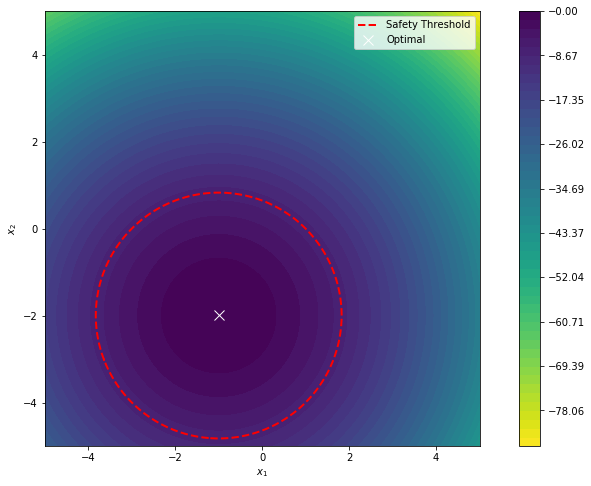

In [2]:
x_opt = fun.get_optimal_x()
y_opt = fun.get_optimal_y()
print(f'y_opt = {y_opt}, x_opt = {x_opt}')

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

Safe seeds:
 X = [[ 0.0501002  -3.57715431]
 [ 0.37074148 -4.11823647]
 [-2.83567134 -0.85170341]
 [ 0.57114228 -0.85170341]
 [-0.99198397 -0.11022044]]
 y = [[-3.59012614]
 [-6.36585797]
 [-4.68827434]
 [-3.78707314]
 [-3.57133104]]
 idx = [ 35752  22268 103608 103778 122200]
Safe seeds:
 X = [[-2.13426854 -4.25851703]]
 y = [[-6.38746431]]


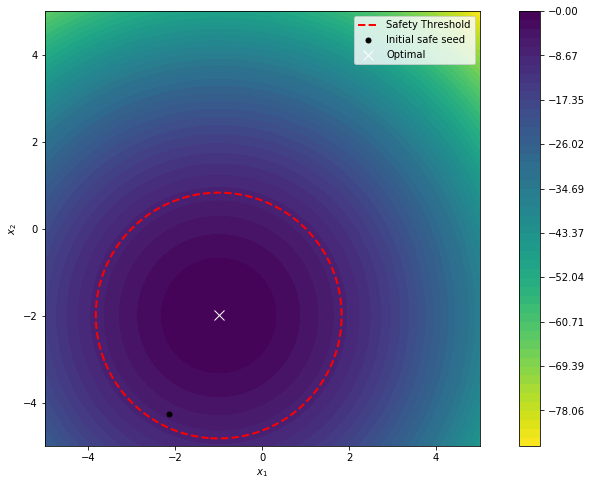

In [3]:
#Random selection (initial safe seed)
from numpy.random import default_rng
random_seed = 44
rng = default_rng(random_seed)
x_safe_seed, y_safe_seed = fun.get_uniform_safe_seeds(rng, n=5)
x_safe_seed, y_safe_seed = fun.get_default_safe_seeds(n=1)

fig, ax, legend = plot_function(fun.x_1, fun.x_2, fun.y, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

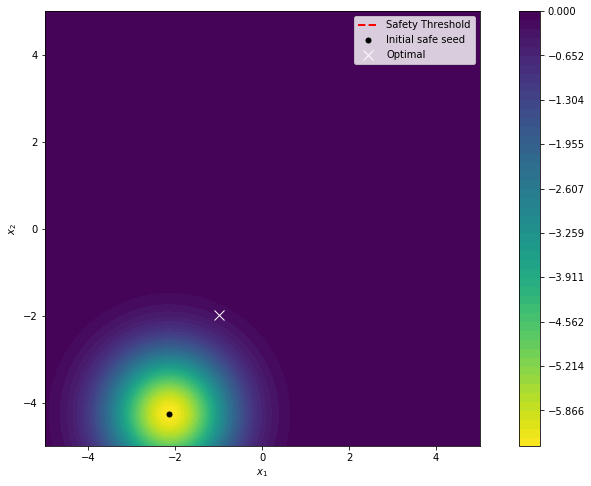

Lipschitz constant = 13.979959919840175


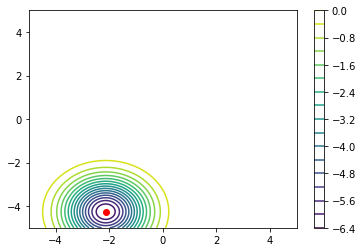

In [4]:
def run_safeopt(opt, fun, iterations, plot=False):
    for i in range(iterations):
        # Obtain next query point
        x_next = opt.optimize()
        # Get a measurement from the real system
        y_meas = fun(x_next)
        # Add this to the GP model
        opt.add_new_data_point(x_next, y_meas)
        print(f'evals={opt.t}\tx_next={x_next}\ty={y_meas}\tsafe={y_meas >= opt.fmin}')
        if plot: opt.plot(500)

def safeopt_stats(opt, fun):
    emax = opt.get_maximum()
    print(f'Estimated maximum = {emax} true_y = {fun(emax[0])}')
    print(f'Max found: {np.max(opt.y)}')
    print(f'Number of failures: {np.sum(opt.y < opt.fmin)} ({fun.n_unsafe})')
    
# Measurement noise, I will add the variance soon
noise_var = 0
# Define Kernel (2-dimensional RBF kernel)
kernel = GPy.kern.RBF(input_dim=fun.xdim, ARD=True)
#kernel = GPy.kern.Matern52(fun.xdim,ARD=True)
# The statistical model of our objective function
gp = GPy.models.GPRegression(x_safe_seed, y_safe_seed, kernel=kernel, noise_var=noise_var)
# The optimization routine
# FIXME: Why beta = 1.96 ?
mean, var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()
opt = SafeOpt(gp, parameter_set=fun.x_matrix, fmin=fun.safe_threshold, lipschitz=fun.lipschitz, beta = 2, threshold=0)
# here, use lipschitz=None for modified safeopt
#opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=fun.safe_threshold, lipschitz=None, beta = 2, threshold=0)
#opt = safeopt.SafeOpt(gp, parameter_set=fun.x_matrix, fmin=[fun.safe_threshold], lipschitz=None, beta = 1.96)
# Plot initial safe seed
opt.plot(500)

evals=2	x_next=[ 3.85771543 -5.        ]	y=-32.5973992072321	safe=[False]
evals=3	x_next=[1.53306613 0.57114228]	y=-13.027196677924987	safe=[False]
evals=4	x_next=[-5.          1.01202405]	y=-25.072288866309773	safe=[False]
evals=5	x_next=[5. 5.]	y=-85.0	safe=[False]
evals=6	x_next=[-1.43286573  5.        ]	y=-49.18737274147493	safe=[False]
evals=7	x_next=[ 5.         -1.19238477]	y=-36.65224236047245	safe=[False]
evals=8	x_next=[-5.  5.]	y=-65.0	safe=[False]
evals=9	x_next=[-1.83366733 -0.65130261]	y=-2.5139858876068777	safe=[ True]
evals=10	x_next=[ 1.09218437 -2.89579158]	y=-5.179677993261071	safe=[ True]
evals=11	x_next=[-5.        -2.4749499]	y=-16.225577407319648	safe=[False]


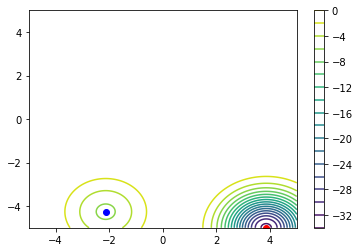

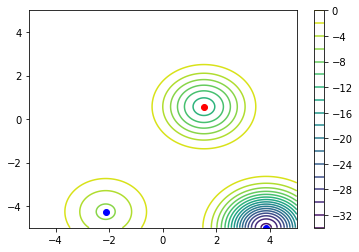

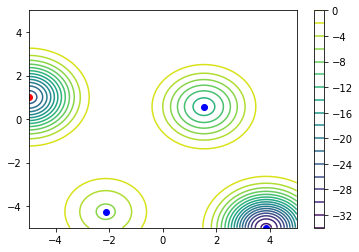

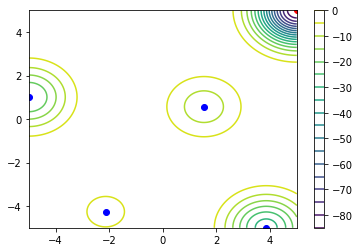

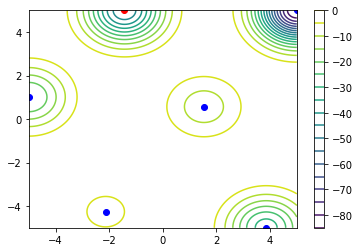

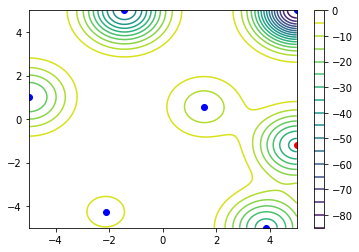

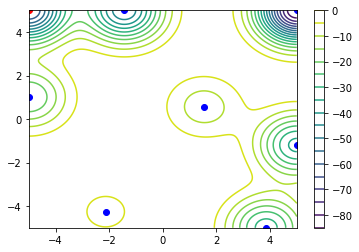

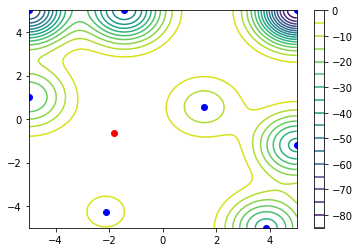

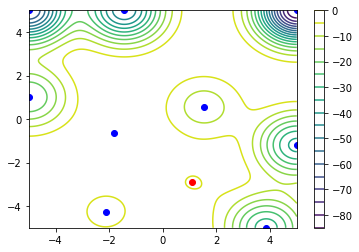

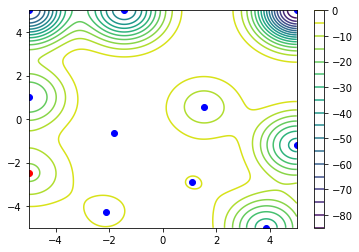

In [5]:
# do 10 iterations
run_safeopt(opt, fun, 10, plot=True)

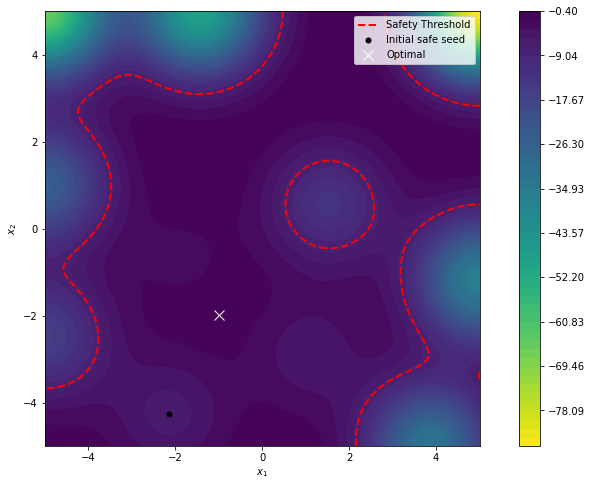

In [6]:
mean, var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()

Estimated maximum = (array([1.69338677, 3.61723447]), -2.4042619770264406) true_y = -38.807655390942195
Max found: -2.5139858876068777
Number of failures: 8 (9)


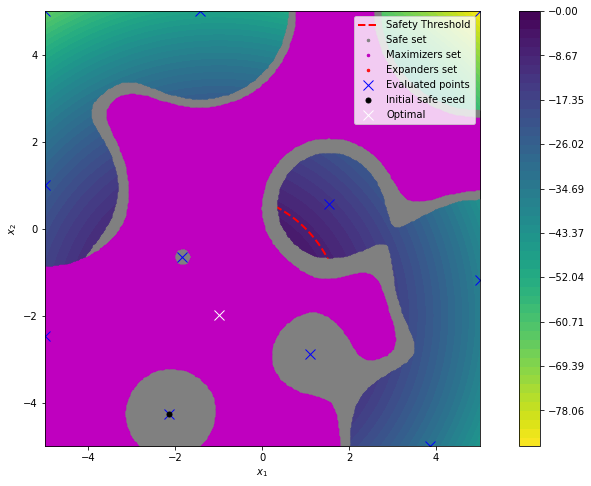

In [7]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

evals=12	x_next=[1.79358717 3.99799599]	y=-43.78008522054129	safe=[False]
evals=13	x_next=[4.63927856 1.91382766]	y=-47.11950956020256	safe=[False]
evals=14	x_next=[-2.23446894  2.23446894]	y=-19.45464074441468	safe=[False]
evals=15	x_next=[-5. -5.]	y=-25.0	safe=[False]
evals=16	x_next=[ 0.23046092 -5.        ]	y=-10.514034080184418	safe=[False]
evals=17	x_next=[0.0501002  2.45490982]	y=-20.948931932000267	safe=[False]
evals=18	x_next=[ 3.35671343 -2.71543086]	y=-19.492793201633724	safe=[False]
evals=19	x_next=[-0.95190381 -2.51503006]	y=-0.2675692065493715	safe=[ True]
evals=20	x_next=[-3.87775551 -0.75150301]	y=-9.840221525214755	safe=[False]
evals=21	x_next=[ 0.250501   -0.91182365]	y=-2.7478805306002765	safe=[ True]
evals=22	x_next=[ 2.41482966 -1.05210421]	y=-12.559568033863318	safe=[False]
evals=23	x_next=[-3.03607214 -2.55511022]	y=-4.45373713358581	safe=[ True]
evals=24	x_next=[-0.71142285  0.79158317]	y=-7.876213348540768	safe=[ True]
evals=25	x_next=[-2.6753507   0.37074148]	

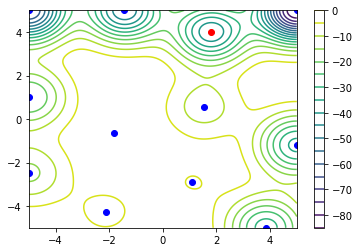

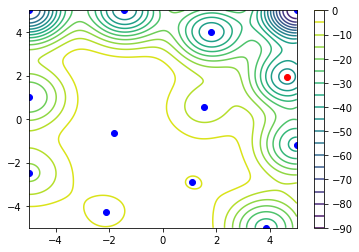

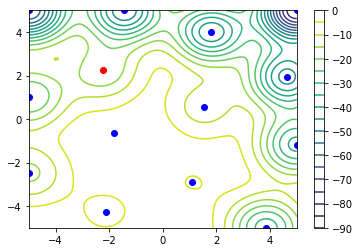

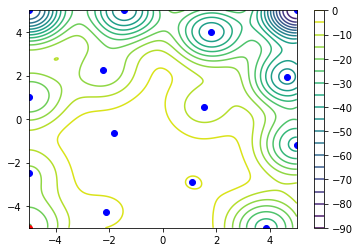

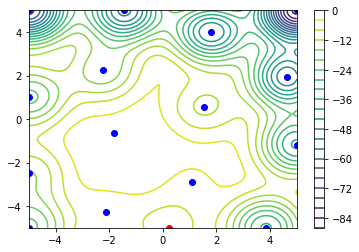

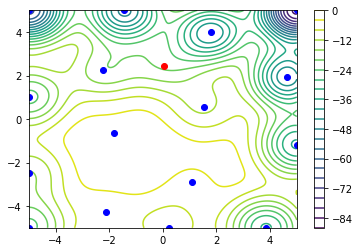

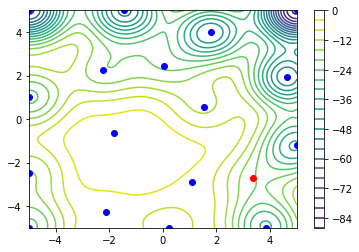

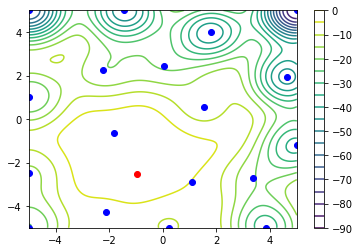

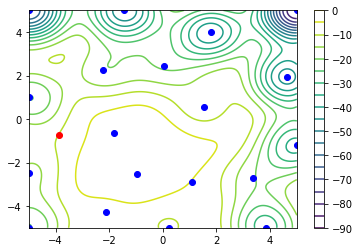

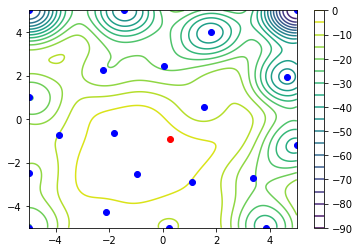

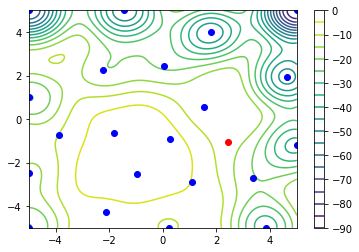

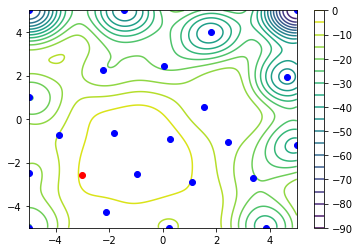

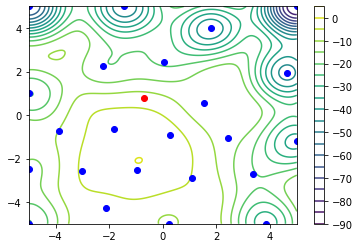

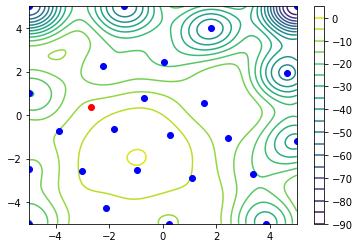

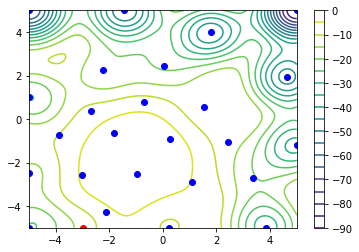

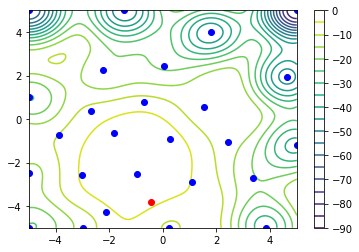

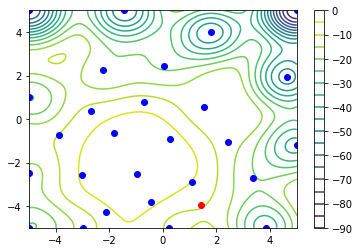

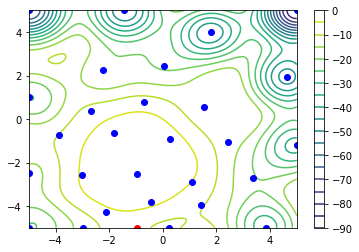

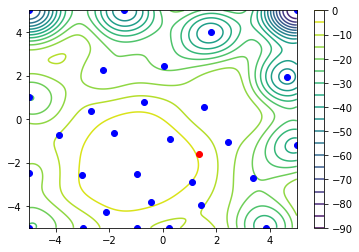

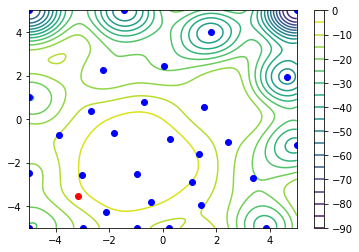

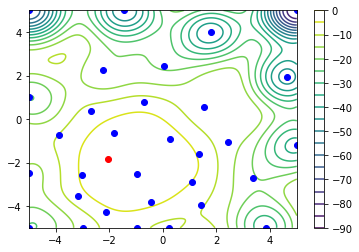

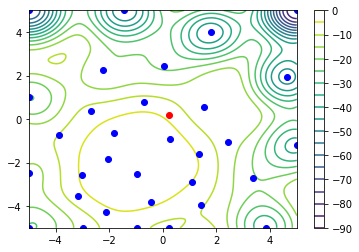

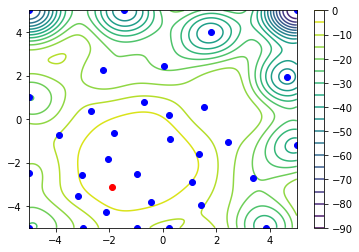

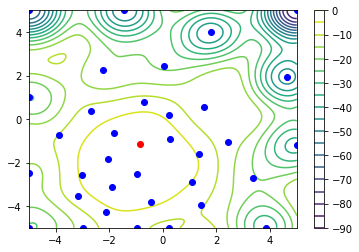

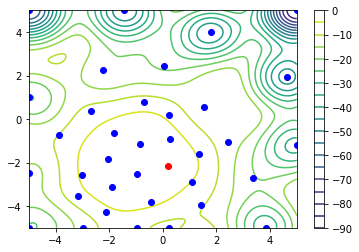

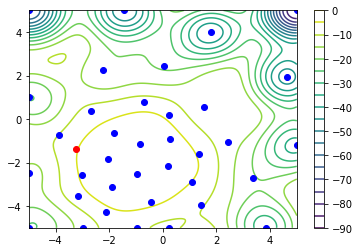

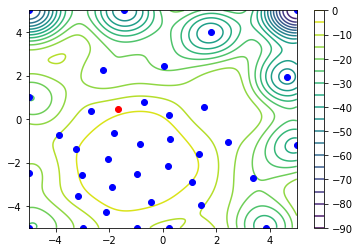

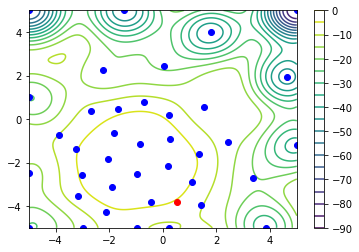

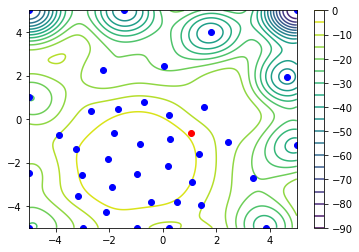

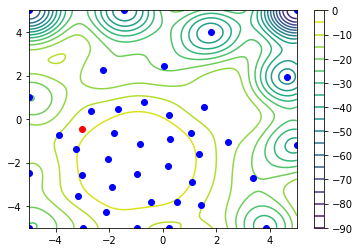

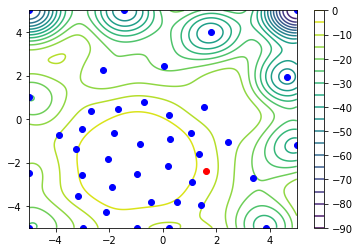

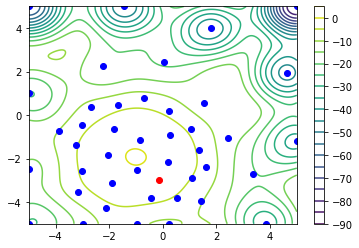

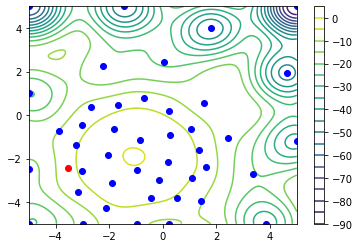

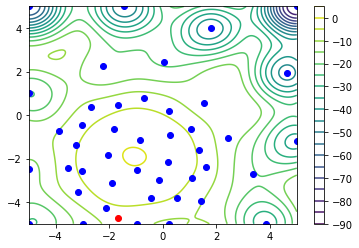

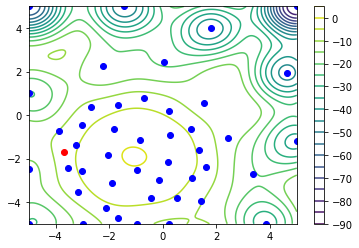

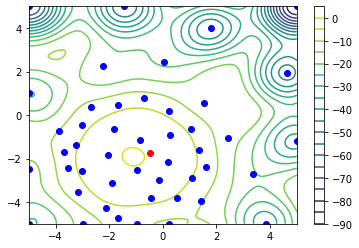

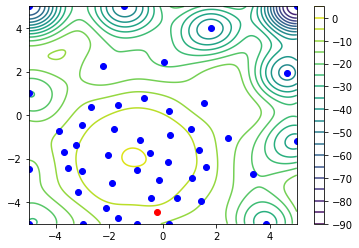

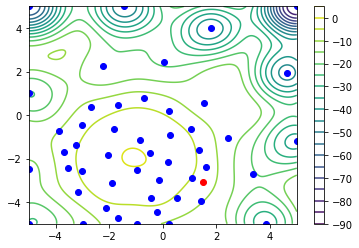

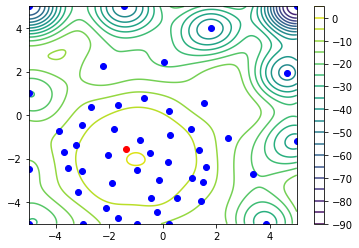

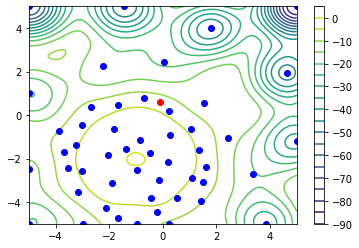

In [8]:
# do 40 more iterations (so far, 50 iterations)
run_safeopt(opt, fun, 40, plot=True)

Estimated maximum = (array([-0.95190381, -2.03406814]), 0.015581624774843872) true_y = -0.0034738816309974802
Max found: -0.2675692065493715
Number of failures: 21 (22)


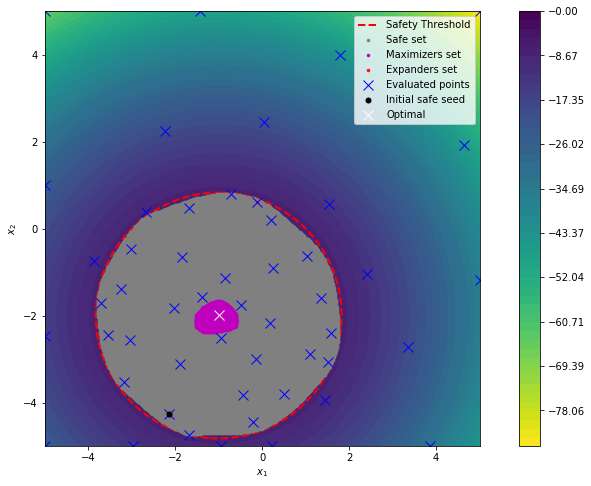

In [9]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)

In [10]:
#do 60 iterations (so far 100 iterations)
run_safeopt(opt, fun, 60, plot=False) # This is very slow!

evals=52	x_next=[ 1.51302605 -0.89178357]	y=-7.543443600628108	safe=[ True]
evals=53	x_next=[-2.81563126 -4.01803607]	y=-7.368986469933855	safe=[ True]
evals=54	x_next=[-1.09218437 -4.65931864]	y=-7.080473572395293	safe=[ True]
evals=55	x_next=[ 0.57114228 -4.25851703]	y=-7.56938727153706	safe=[ True]
evals=56	x_next=[0.57114228 0.17034068]	y=-7.178866751539147	safe=[ True]
evals=57	x_next=[ 1.71342685 -1.61322645]	y=-7.512279067152337	safe=[ True]
evals=58	x_next=[-1.55310621 -2.25450902]	y=-0.3707013224846489	safe=[ True]
evals=59	x_next=[-3.0761523  -0.13026052]	y=-7.806334111107988	safe=[ True]
evals=60	x_next=[-1.47294589  0.73146293]	y=-7.684567531857302	safe=[ True]
evals=61	x_next=[-3.57715431 -2.9759519 ]	y=-7.594206448970086	safe=[ True]


KeyboardInterrupt: 

In [ ]:
safeopt_stats(opt, fun)
plot_all(fun, opt, x_safe_seed, x_opt)
mean,  var = gp.predict_noiseless(fun.x_matrix)
fig, ax, legend = plot_function(fun.x_1, fun.x_2, mean, fun.safe_threshold)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_opt, fig, ax, legend)
plt.show()